# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
27.02.2023<br>
Erik Holopainen, Alejandro Rosales Rodriguez and Brian van den Berg<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

Instructions: Write here why this Notebook was created, what were the main objectives.

## 2. Setup

Instructions: Write here shortly what libraries were used and why.

In [275]:
# Machine Learning and Data Science
import pandas as pd
import numpy as np
import tensorflow as tf

# Modeling neural networks
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input, Activation, Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# General imports
import os

## 3. Dataset

Instructions: Describe here brielfy the data and its main characteristics. Remember document the code.  

In [276]:
# Define the input variables
inputDir = 'input'
inputPaths = []

# Get the .csv files in the input folder
for file in os.listdir(inputDir):
    if file.endswith('.csv'):
        inputPaths.append(os.path.join(inputDir, file))

# Print the input paths
print(inputPaths)

# Define the dataframe
df = pd.DataFrame()

# Append all the input files
for path in inputPaths:
    df = pd.concat([df, pd.read_csv(path)], ignore_index=True)

# Drop the unique id column
df = df.drop(['uniqueID'], axis=1)

# Shuffle the dataframe
df = df.sample(frac=1)
df = df.reset_index(drop=True)

# Display the dataframe
display(df)

# Display the dataframe description
print("Description of the dataframe:")
display(df.describe().T)

['input\\drugsComTest_raw.csv', 'input\\drugsComTrain_raw.csv']


,drugName,condition,review,rating,date,usefulCount
0,Ceftriaxone,Urinary Tract Infection,"""Had rocephin for bronchitis once and it worke...",10,26-Feb-16,10
1,Disulfiram,Alcohol Dependence,"""Knowing how sick I&#039;ll get makes it possi...",10,12-Jul-13,147
2,Plan B,Emergency Contraception,"""When I read all of these reviews, on every pa...",10,6-May-16,10
3,Silodosin,Benign Prostatic Hyperplasia,"""Doctor did not warn about the dry ejaculate s...",10,15-Sep-11,52
4,Diazepam,Anxiety,"""Was given 5mg to take up to 3 times per day f...",4,12-Oct-17,1
...,...,...,...,...,...,...
215058,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I got the shot for the first time in December...",1,9-Mar-16,5
215059,Triamcinolone,Dermatitis,"""I used this cream for the first time and with...",1,2-Nov-16,8
215060,Ritalin,ADHD,"""I&#039;m 28 yrs old and just started taking t...",9,9-Nov-12,62
215061,Implanon,Birth Control,"""I have had this birth control in since March ...",10,7-Apr-11,1


Description of the dataframe:


,count,mean,std,min,25%,50%,75%,max
rating,215063.0,6.990008,3.275554,1.0,5.0,8.0,10.0,10.0
usefulCount,215063.0,28.001004,36.346069,0.0,6.0,16.0,36.0,1291.0


## 4. Preprocessing

Instructions: Describe:

- how the missing values are handled
- conversion of textual and categorical data into numerical values (if needed)
- how the data is splitted into train, validation and test sets
- the features (=input) and labels (=output), and 
- how the features are normalized or scaled

### Tokenize

In [277]:
# Get the reviews
X = list(df['review'])

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Tokenize the reviews
X = tokenizer.texts_to_sequences(X)

# Print out the number of unique tokens
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Get the biggest sequence in the data
max_sequence = 0
for seq in X:
    if len(seq) > max_sequence:
        max_sequence = len(seq)
print(f'The maximum amount of words that the model can process is {max_sequence}.')

# Apply padding to make all sequences an equal size
X = np.array(pad_sequences(X, maxlen=200))

Found 55245 unique tokens.
The maximum amount of words that the model can process is 2034.


### Simplify and Encode the Labels

In [278]:
# Get the ratings
y = list(df['rating'])

# Simplification function
def simplify(num):
    if num < 5:
        return 0
    elif num > 6:
        return 2
    else:
        return 1

# Simplify the labels
y = np.array(list(map(simplify, y)))

# Calculate the class weights
total = len(y)
unique, counts = np.unique(y, return_counts=True)

# Encode the labels for multi classification
y = np.array(to_categorical(y))

# Print the distribution
print(f'The unique labels are: [{unique[0]}, {unique[1]}, {unique[2]}] with a distribution of [{counts[0]}, {counts[1]}, {counts[2]}].')

The unique labels are: [0, 1, 2] with a distribution of [53572, 19185, 142306].


## 5. Modeling

Instructions: Write a short description of the model: 

- selected loss, optimizer and metrics settings, and 
- the summary of the selected model architecture. 

In [279]:
# Defining the model
embedding_dim = 100
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim),
    Dropout(.2),
    Conv1D(128, 7, padding="valid", activation="relu", strides=3),
    GlobalAveragePooling1D(),
    Dense(3, activation='softmax')
])

# Compiling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', 'Recall', 'TrueNegatives', 'FalsePositives'])

# Summarizing
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, None, 100)         5524600   
                                                                 
 dropout_55 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_38 (Conv1D)          (None, None, 128)         89728     
                                                                 
 global_average_pooling1d_38  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_75 (Dense)            (None, 3)                 387       
                                                                 
Total params: 5,614,715
Trainable params: 5,614,715
Non-trainable params: 0
___________________________________________

## 6. Training

Instructions: Write a short description of the training process, and document the code for training and the total time spend on it. 

In [280]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train, X_val,  y_train, y_val =  train_test_split(X_train, y_train, test_size=.2, stratify=y_train)

# Model Fitting
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/10
 605/1076 [===============>..............] - ETA: 4:08:30 - loss: 0.6650 - Accuracy: 0.7391 - recall: 0.7013 - true_negatives: 138050.0000 - false_positives: 16830.0000

KeyboardInterrupt: 

## 7. Performance and evaluation

Instructions: 

- Show the training and validation loss and accuracy plots
- Interpret the loss and accuracy plots (e.g. is there under- or over-fitting)
- Describe the final performance of the model with test set 

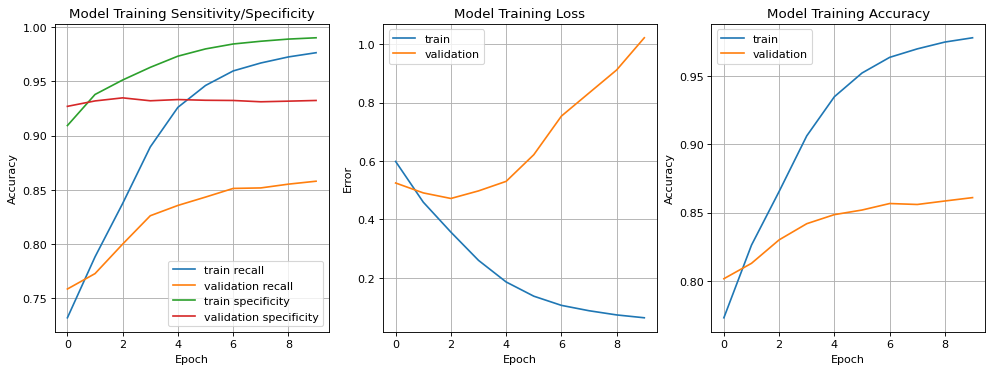

In [ ]:
# Define the function to calculate the specificity
def spec(a, b):
    return a / (a + b)

# Define a function to plot the sensitivity and specificity
def plotBalance(h, name):
    # Calculate the specificity
    specificity = list(map(spec, h.history['true_negatives'], h.history['false_positives']))
    val_specificity = list(map(spec, h.history['val_true_negatives'], h.history['val_false_positives']))

    # Plot the recall curve
    plt.plot(h.history['recall'], label='train recall')
    plt.plot(h.history['val_recall'], label='validation recall')

    # Plot the specificity curve
    plt.plot(specificity, label='train specificity')
    plt.plot(val_specificity, label='validation specificity')

    # Define the graph
    plt.title('{0} Training Sensitivity/Specificity'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define a function to plot the loss curve
def plotLoss(h, name):
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('{0} Training Loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# Plot the Accuracy curve
def plotAccuracy(h, name):
    plt.plot(h.history['Accuracy'], label='train')
    plt.plot(h.history['val_Accuracy'], label='validation')
    plt.title('{0} Training Accuracy'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define the sub-plot size
nCols = 3
nRows = 1

# Prepare the Loss Plots
plt.figure(figsize=(nCols * 5, nRows * 5), dpi=80)

# Plot the Sensitivity/Specificity
plt.subplot(nRows, nCols, 1)
plotBalance(history, 'Model')

# Plot the Loss
plt.subplot(nRows, nCols, 2)
plotLoss(history, 'Model')
    
# Plot the Accuracy
plt.subplot(nRows, nCols, 3)
plotAccuracy(history, 'Model')

# Draw the plots
plt.show()



## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
- What are your main observations and learning points
- Discussion how the model could be improved in future 

**Note:** Remember to evaluate the final metrics using the test set. 
